# Demand Time Series

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy
import warnings, pylab

warnings.filterwarnings('ignore')

# setting of the plotting style, registers pandas date converters for matplotlib and the default figure size
import seaborn as sns
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc("figure", figsize=(25, 5))
sns.mpl.rc("font", size=14)

In [457]:
# загружаем данные
ts_retail = pd.read_csv('./train_kaggle.csv', sep=',')

ts_retail.head()

,Store_id,SKU_id,Date,Promo,Demand,Regular_Price,Promo_Price
0,1,1,01.01.2015,NaN,22,163.78,NaN
1,1,1,02.01.2015,NaN,41,163.78,NaN
2,1,1,03.01.2015,NaN,35,163.78,NaN
3,1,1,04.01.2015,NaN,72,163.78,NaN
4,1,1,05.01.2015,NaN,25,163.78,NaN


In [458]:
ts_retail_test = pd.read_csv('./test_kaggle.csv', sep=',')

In [459]:
def process(data):
  data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
  data.set_index(['Date'], inplace=True)
  data['Promo'] = data['Promo'].fillna(0)
  data.reset_index().set_index(['SKU_id', 'Store_id', 'Date'], inplace=True)
  data['Regular_Price'] = data['Regular_Price'].ffill().bfill()
  data.reset_index().set_index(['Date'], inplace=True)

  # add actual price (promo price when promo occurred or regular price otherwise)
  data['Actual_Price'] = data['Promo_Price'].combine_first(data['Regular_Price'])
  data['Promo_percent'] = (1 - (data['Actual_Price'] / data['Regular_Price']))
  data = data.drop('Promo_Price', axis=1)

  data.reset_index(inplace=True)
  data["weekday"] = data['Date'].dt.weekday
  data["monthday"] = data['Date'].dt.day
  data['is_weekend'] = data['weekday'].isin([5, 6]) * 1
  data['month_period'] = 0
  data.loc[data['monthday'] >= 15, 'month_period'] = 1

  ## base feature

  data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['Demand'].expanding().mean().droplevel(['Store_id', 'SKU_id'])
  data['demand_expanding_mean'] = data.groupby(['Store_id', 'SKU_id'])['demand_expanding_mean'].apply(lambda x: x.shift(14))


  return data

In [460]:
ts_retail = process(ts_retail)

In [461]:
ts_retail_test = process(ts_retail_test)

In [462]:
from ipywidgets import IntProgress

def percentile(n):
  """
  Calculate n - percentile of data
  """
  def percentile_(x):
      return np.nanpercentile(x, n)

  percentile_.__name__ = 'perc%s' % n
  return percentile_

## add missing dates to GroupBy.Core object
def fill_missing_dates(x, date_col):
  min_date, max_date = x[date_col].min(), x[date_col].max()
  groupby_day = x.groupby(pd.PeriodIndex(x[date_col], freq='D'))
  results = groupby_day.sum(min_count=1)

  idx = pd.period_range(min_date, max_date)
  results = results.reindex(idx, fill_value=np.nan)

  results.index.rename(date_col, inplace=True)

  return results


def calc_preag_fill(data, group_col, date_col, target_cols, preagg_method):
  ## calc preaggregation
  data_preag = data.groupby(group_col).agg(
      preagg_method)[target_cols].reset_index()

  ## fill missing dates
  data_preag_filled = data_preag.groupby(group_col[:-1]).apply(
      fill_missing_dates, date_col=date_col).drop(group_col[:-1],
                                                  axis=1).reset_index()

  ## return DataFrame with calculated preaggregation and filled missing dates
  return data_preag_filled


def calc_rolling(data_preag_filled, group_col, date_col, method, w):
  ## calc rolling stats
  lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
      apply(lambda x: x.set_index(date_col).rolling(window=w, min_periods=1).agg(method)).drop(group_col[:-1], axis=1)

  ## return DataFrame with rolled columns from target_vars
  return lf_df_filled


def calc_ewm(data_preag_filled, group_col, date_col, span):
  ## calc ewm stats
  lf_df_filled = data_preag_filled.groupby(group_col[:-1]).\
      apply(lambda x: x.set_index(date_col).ewm(span=span).mean()).drop(group_col[:-1], axis=1)

  ## return DataFrame with rolled columns from target_vars
  return lf_df_filled


def shift(lf_df_filled, group_col, date_col, lag):
  lf_df = lf_df_filled.groupby(
      level=group_col[:-1]).apply(lambda x: x.shift(lag)).reset_index()
  lf_df[date_col] = pd.to_datetime(lf_df[date_col].astype(str))

  ## return DataFrame with following columns: filter_col, id_cols, date_col and shifted stats
  return lf_df


def generate_lagged_features(
      data: pd.DataFrame,
      target_cols: list = ['Demand'],
      id_cols: list = ['SKU_id', 'Store_id'],
      date_col: str = 'Date',
      lags: list = [7, 14, 21, 28],
      windows: list = ['7D', '14D', '28D', '56D'],
      preagg_methods: list = ['mean'],
      agg_methods: list = ['mean', 'median', percentile(10), pd.Series.skew],
      dynamic_filters: list = ['weekday', 'Promo'],
      ewm_params: dict = {'weekday': [14, 28], 'Promo': [14, 42]}) -> pd.DataFrame:

  ''' 
  data - dataframe with default index
  target_cols - column names for lags calculation
  id_cols - key columns to identify unique values
  date_col - column with datetime format values
  lags - lag values(days)
  windows - windows(days/weeks/months/etc.),
      calculation is performed within time range length of window
  preagg_methods - applied methods before rolling to make
      every value unique for given id_cols
  agg_methods - method of aggregation('mean', 'median', percentile, etc.)
  dynamic_filters - column names to use as filter
  ewm_params - span values(days) for each dynamic_filter
  '''

  data = data.sort_values(date_col)
  out_df = deepcopy(data)
  dates = [min(data[date_col]), max(data[date_col])]

  total = len(target_cols) * len(lags) * len(windows) * len(preagg_methods) * len(agg_methods) * len(dynamic_filters)
  progress = IntProgress(min=0, max=total)
  display(progress)

  for filter_col in dynamic_filters:
    group_col = group_col = [filter_col] + id_cols + [date_col]
    for lag in lags:
      for preagg in preagg_methods:
        data_preag_filled = calc_preag_fill(data, group_col, date_col,
                                            target_cols, preagg)

        ## add ewm features
        for alpha in ewm_params.get(filter_col, []):
          ewm_filled = calc_ewm(data_preag_filled, group_col,
                                date_col, alpha)
          ewm = shift(ewm_filled, group_col, date_col, lag)
          new_names = {x: "{0}_lag{1}d_alpha{2}_key{3}_preag{4}_{5}_dynamic_ewm".\
              format(x, lag, alpha, '_'.join(id_cols), preagg, filter_col) for x in target_cols}

          out_df = pd.merge(out_df,
                            ewm.rename(columns=new_names),
                            how='left',
                            on=group_col)

        for w in windows:
          for method in agg_methods:
              rolling_filled = calc_rolling(data_preag_filled,
                                            group_col, date_col,
                                            method, w)

              ## lf_df - DataFrame with following columns: filter_col, id_cols, date_col, shifted rolling stats
              rolling = shift(rolling_filled, group_col, date_col,
                              lag)

              method_name = method.__name__ if type(
                  method) != str else method

              new_names = {x: "{0}_lag{1}d_w{2}_key{3}_preag{4}_ag{5}_{6}_dynamic_rolling".\
                            format(x, lag, w, '_'.join(id_cols), preagg, method_name, filter_col) for x in target_cols}

              out_df = pd.merge(out_df,
                                rolling.rename(columns=new_names),
                                how='left',
                                on=group_col)
              progress.value += 1

  return out_df


In [463]:
ts_retail['NoFilter'] = 1

In [464]:
ts_retail_test['NoFilter'] = 1

In [502]:
target_cols = ['Demand']
id_cols = ['SKU_id']
date_col = 'Date'

data_lagged_features = generate_lagged_features(ts_retail 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [28, 35, 42]
                    , windows = ['21D', '28D']
                    , preagg_methods = ['mean', 'sum', 'count'] # ['mean', 'count']
                    , agg_methods = ['mean', 'median', percentile(10),  percentile(90), percentile(25),  percentile(75)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [28, 42], 'Promo': [28, 42]}
                    )

IntProgress(value=0, max=216)

IntProgress(value=0, max=216)

In [486]:
data_lagged_features_test = generate_lagged_features(ts_retail_test 
                    , target_cols = target_cols
                    , id_cols = id_cols
                    , date_col = date_col
                    , lags = [28, 35, 42]
                    , windows = ['7D', '14D', '28D', '56D']
                    , preagg_methods = ['mean'] # ['mean', 'count']
                    , agg_methods = ['mean', 'median', percentile(10),  percentile(90)]
                    , dynamic_filters = ['Promo', 'NoFilter']
                    , ewm_params={'NoFilter': [28, 42], 'Promo': [28, 42]}
                    )

IntProgress(value=0, max=96)

In [487]:
# number of columns
print(len(data_lagged_features.columns))
data_lagged_features.columns

122


Index(['Date', 'Store_id', 'SKU_id', 'Promo', 'Demand', 'Regular_Price',
       'Actual_Price', 'Promo_percent', 'weekday', 'monthday',
       ...
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc10_NoFilter_dynamic_rolling',
       'Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_NoFilter_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmean_NoFilter_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_NoFilter_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_NoFilter_dynamic_rolling',
       'Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_NoFilter_dynamic_rolling',
       'Demand_lag42d_w56D_keySKU_id_preagmean_agmean_NoFilter_dynamic_rolling',
       'Demand_lag42d_w56D_keySKU_id_preagmean_agmedian_NoFilter_dynamic_rolling',
       'Demand_lag42d_w56D_keySKU_id_preagmean_agperc10_NoFilter_dynamic_rolling',
       'Demand_lag42d_w56D_keySKU_id_preagmean_agperc90_NoFilter_dynamic_rolling'],
      dtype='object', leng

## ML Model Training

In [488]:
data_lagged_features_ml = data_lagged_features.set_index(['Date'])

In [489]:
data_lagged_features_ml

,Store_id,SKU_id,Promo,Demand,Regular_Price,Actual_Price,Promo_percent,weekday,monthday,is_weekend,...,Demand_lag42d_w14D_keySKU_id_preagmean_agperc10_NoFilter_dynamic_rolling,Demand_lag42d_w14D_keySKU_id_preagmean_agperc90_NoFilter_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agmean_NoFilter_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agmedian_NoFilter_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agperc10_NoFilter_dynamic_rolling,Demand_lag42d_w28D_keySKU_id_preagmean_agperc90_NoFilter_dynamic_rolling,Demand_lag42d_w56D_keySKU_id_preagmean_agmean_NoFilter_dynamic_rolling,Demand_lag42d_w56D_keySKU_id_preagmean_agmedian_NoFilter_dynamic_rolling,Demand_lag42d_w56D_keySKU_id_preagmean_agperc10_NoFilter_dynamic_rolling,Demand_lag42d_w56D_keySKU_id_preagmean_agperc90_NoFilter_dynamic_rolling
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,1,1,0.0,22,163.78,163.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,47,2,0.0,0,142.57,142.57,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,31,1,0.0,28,163.78,163.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,70,2,0.0,0,135.78,135.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,48,2,0.0,0,135.78,135.78,0.000000,3,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-22,77,1,1.0,518,128.98,119.60,0.072724,6,22,1,...,134.554860,163.553061,256.658734,162.575426,138.040574,657.102062,273.699663,179.883913,142.239796,615.664948
2016-05-22,78,1,1.0,858,128.98,119.60,0.072724,6,22,1,...,134.554860,163.553061,256.658734,162.575426,138.040574,657.102062,273.699663,179.883913,142.239796,615.664948
2016-05-22,66,2,0.0,3,138.50,138.50,0.000000,6,22,1,...,2.877551,4.068557,17.470507,4.041132,3.020408,57.372165,12.605721,4.025668,3.051020,55.762887


In [490]:
# train specific model for each SKU
sku1_train = data_lagged_features_ml[data_lagged_features_ml['SKU_id'] == 1]
sku2_train = data_lagged_features_ml[data_lagged_features_ml['SKU_id'] == 2]

In [491]:
data_lagged_features_ml_test = data_lagged_features_test.set_index(['Date'])

In [492]:
# test specific model for each SKU
sku1_test = data_lagged_features_ml_test[data_lagged_features_ml_test['SKU_id'] == 1]
sku2_test = data_lagged_features_ml_test[data_lagged_features_ml_test['SKU_id'] == 2]

In [411]:
# try lightgbm as ml algorithm
import lightgbm as lgb
kwargs={'early_stopping_rounds':10,'verbose':2}

def plot_feature_importance(model, X , num = 20): 
  # , fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # plt.figure(figsize=fig_size)
    # sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances-01.png')
    plt.show()

In [493]:
# without CV
lgbm1 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')
lgbm1.fit(X = sku1_train.drop(['SKU_id','Demand'], axis=1), y = sku1_train.Demand)

lgbm2 = lgb.LGBMRegressor(
                        n_estimators=500,
                        learning_rate=0.1,
                        feature_fraction=0.7,
                        subsample=0.4,
                        num_leaves=40,
                        metric='mae')

lgbm2.fit(X = sku2_train.drop(['SKU_id','Demand'], axis=1), y = sku2_train.Demand)

LGBMRegressor(feature_fraction=0.7, metric='mae', n_estimators=500,
              num_leaves=40, subsample=0.4)

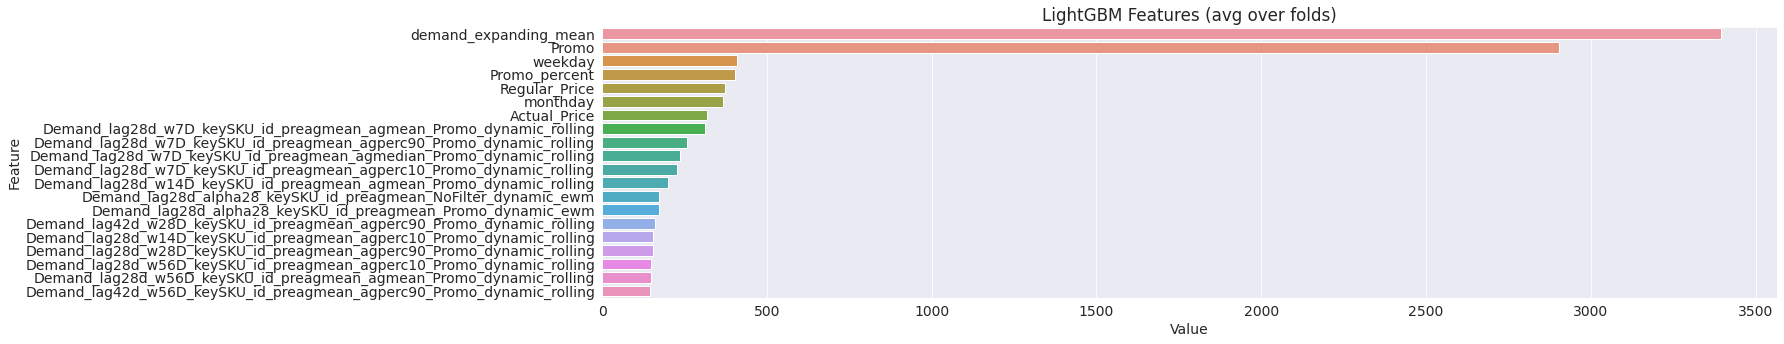

In [494]:
plot_feature_importance(lgbm1, sku1_train[sku1_train.columns[2:]], num = 20)

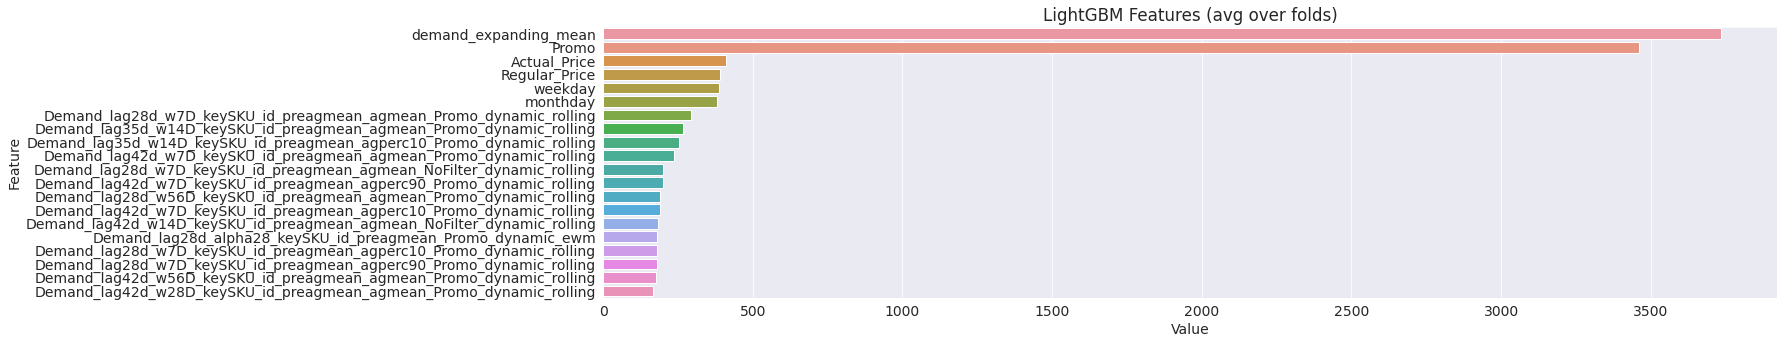

In [495]:
plot_feature_importance(lgbm2, sku2_train[sku2_train.columns[2:]], num = 20)

### Cross-validation for time series
 **Caution**: ml parameters tuning steps are omitted! Only tech approach is shown.

In [477]:
#  time series cross validation
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics, kwargs={}):
    print('Size train set: {}'.format(X_train.shape))

    # size of a fold
    fold_size = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(fold_size))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print('')
        train_share = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(fold_size*i)]
        y = y_train[:(fold_size*i)]
        print('Size of train and test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * train_share))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds, **kwargs, eval_set=[(X_testFold, y_testFold)])
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [496]:
# Train sets
X_train1 = sku1_train.drop(['SKU_id','Demand'], axis=1)
y_train1 = sku1_train.Demand
X_train2 = sku2_train.drop(['SKU_id', 'Demand'], axis=1)
y_train2 = sku2_train.Demand

In [380]:
# WAPE realizaion for lgbm train
def wape(y_pred, y_true):
    res = np.sum(np.abs(y_true - y_pred)) / np.sum(y_true) * 100
    return res

In [497]:
# run TS CV for the sku 1 (if needed)
%%time
performTimeSeriesCV(X_train1, y_train1, 17, lgbm1, wape, kwargs)

Size train set: (43733, 119)
Size of each fold: 2572

Splitting the first 2 chunks at 1/2
Size of train and test: (5144, 119)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 251.677
[4]	valid_0's l1: 236.83
[6]	valid_0's l1: 225.303
[8]	valid_0's l1: 221.222
[10]	valid_0's l1: 211.888
[12]	valid_0's l1: 205.466
[14]	valid_0's l1: 201.114
[16]	valid_0's l1: 197.834
[18]	valid_0's l1: 195.556
[20]	valid_0's l1: 193.748
[22]	valid_0's l1: 192.875
[24]	valid_0's l1: 191.866
[26]	valid_0's l1: 191.248
[28]	valid_0's l1: 190.681
[30]	valid_0's l1: 190.098
[32]	valid_0's l1: 189.933
[34]	valid_0's l1: 189.719
[36]	valid_0's l1: 189.547
[38]	valid_0's l1: 189.404
[40]	valid_0's l1: 189.815
[42]	valid_0's l1: 190.04
[44]	valid_0's l1: 189.783
[46]	valid_0's l1: 189.695
[48]	valid_0's l1: 189.61
Early stopping, best iteration is:
[39]	valid_0's l1: 189.376

Splitting the first 3 chunks at 2/3
Size of train and test: (7716, 119)
Training until validation scores don

50.273764835191564

In [498]:
# run TS CV for the sku 2 (if needed)
%%time
performTimeSeriesCV(X_train2, y_train2, 17, lgbm2, wape, kwargs)

Size train set: (43183, 119)
Size of each fold: 2540

Splitting the first 2 chunks at 1/2
Size of train and test: (5080, 119)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 3.36808
[4]	valid_0's l1: 3.25366
[6]	valid_0's l1: 3.17027
[8]	valid_0's l1: 3.10232
[10]	valid_0's l1: 3.04817
[12]	valid_0's l1: 3.01245
[14]	valid_0's l1: 2.98269
[16]	valid_0's l1: 2.99761
[18]	valid_0's l1: 2.98388
[20]	valid_0's l1: 2.95161
[22]	valid_0's l1: 2.93755
[24]	valid_0's l1: 2.94764
[26]	valid_0's l1: 2.94388
[28]	valid_0's l1: 2.94508
[30]	valid_0's l1: 2.963
[32]	valid_0's l1: 2.96732
Early stopping, best iteration is:
[23]	valid_0's l1: 2.9303

Splitting the first 3 chunks at 2/3
Size of train and test: (7620, 119)
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's l1: 2.66626
[4]	valid_0's l1: 2.5435
[6]	valid_0's l1: 2.44124
[8]	valid_0's l1: 2.36647
[10]	valid_0's l1: 2.30668
[12]	valid_0's l1: 2.27308
[14]	valid_0's l1: 2.2483
[16]	va

92.40319568911127

In [499]:
# Test sets
X_test1 = sku1_test.drop(['SKU_id','Demand'], axis=1)
y_test1 = sku1_test.Demand
X_test2 = sku2_test.drop(['SKU_id', 'Demand'], axis=1)
y_test2 = sku2_test.Demand

## Forecast Generation with ML

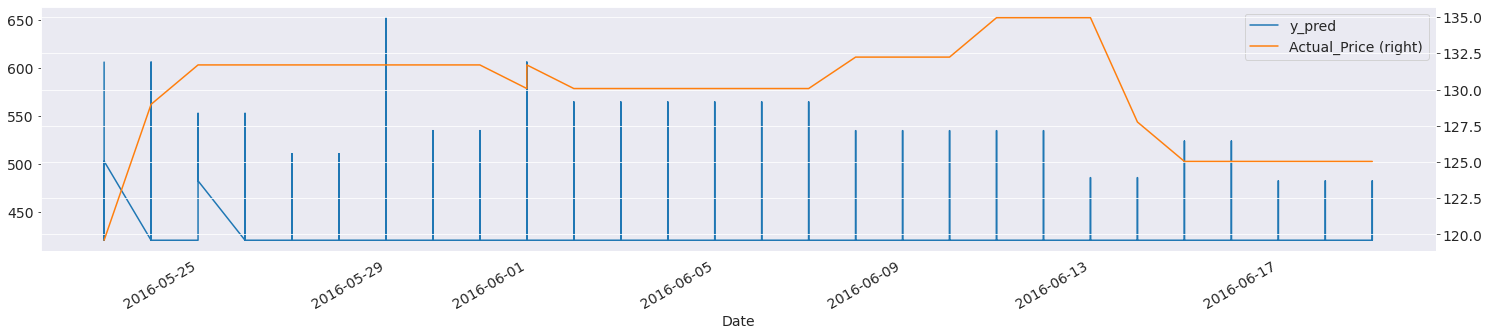

In [500]:
# forecast for sku 1
X_test1['y_pred'] = lgbm1.predict(X_test1[X_test1.columns[:-1]])
X_test1[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

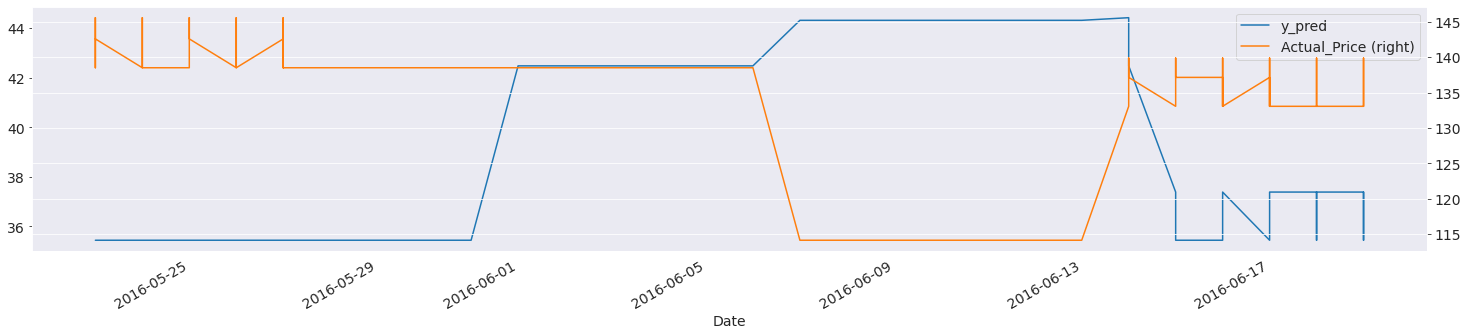

In [501]:
X_test2['y_pred'] = lgbm2.predict(X_test2[X_test2.columns[:-1]])
X_test2[['y_pred', 'Actual_Price']].plot(secondary_y = ['Actual_Price'])

In [483]:
result = pd.concat([X_test1.reset_index(), X_test2.reset_index()], sort=False, axis=0).reset_index().sort_values(by=['id'])

In [446]:
with open('csv_data.csv', 'w') as csv_file:
  result.to_csv(path_or_buf=csv_file, index=False, header=['id', 'Demand'], columns=['id', 'y_pred'])

In [484]:
result[['id', 'y_pred']]

,id,y_pred
0,0,615.703478
183,1,565.713305
307,2,565.713305
407,3,565.713305
504,4,565.713305
...,...,...
5439,5965,52.877525
5563,5966,52.671340
5660,5967,52.671340
5849,5968,52.849090
